In [1]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    fbeta_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
    brier_score_loss,
)
import numpy as np
import pandas as pd
import time
import mlflow
import lightgbm as lgb
import os
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.types as spark_types

from mlflow.tracking.client import MlflowClient

ModuleNotFoundError: No module named 'pyspark'

In [0]:

mlflow.set_registry_uri("databricks-uc")

In [0]:
experiment_name = f"/cancer_classification_prediction"
run_name = "cancer_classification_prediction_" + str(pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"))
full_model_name = "cancer_classification_model"

LABEL = "Target"
y_pred_threshold = 0.5

In [0]:
mlflow_metrics = {} # a place to pop new metrics into
mlflow_figures = {} # a place to pop new matplotlib/sns figures into
mlflow_tables = {} # a place to pop new matplotlib/sns figures into
mlflow_artifact_paths = []

def push_metric(metric_name: str, metric_value: any) -> None:
    print(f"Adding metric {metric_name}: {metric_value}")
    mlflow_metrics[metric_name] = metric_value

def push_figure(figure_name: str, figure_value: any):
    print(f"Adding figure {figure_name}: {figure_value}")
    mlflow_figures[figure_name] = figure_value

def push_table(table_name: str, table_value: any):
    print(f"Adding table {table_name}: {table_value}")
    mlflow_tables[table_name] = table_value

def push_artifact(file_path: str):
    print(f"Adding artifact {file_path}")
    mlflow_artifact_paths.append(file_path)

In [0]:
mlflow.set_registry_uri("databricks-uc")
mlflow.set_experiment(experiment_name)
run = mlflow.start_run(run_name=run_name, description=f"Creating predictions for {experiment_name} using model {full_model_name}")
print(f"creating run called {run.info.run_name}")

creating run called cancer_classification_prediction_2025-06-18 11:40:47


In [0]:
preddf = pd.read_csv('../data/pred.csv')

In [0]:
preddf.describe()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Target,hour,day,weekday,month,year,BMI_HOMA,L_A_ratio
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.0,16.0,16.000000,16.000000
mean,55.750000,28.716246,96.409375,2.073984,2.073303,3.096644,9.247793,2.596799,5.966502,0.437500,10.375000,11.000000,3.312500,6.0,2025.0,63.499570,0.478616
std,17.860571,6.085963,28.371137,0.566565,1.863471,0.779736,5.733933,0.568737,0.753188,0.512348,5.690636,5.202563,2.056494,0.0,0.0,62.211016,0.317092
min,28.000000,20.260000,70.000000,1.319086,0.519184,2.032481,2.784910,1.710188,4.219891,0.000000,2.000000,3.000000,0.000000,6.0,2025.0,13.135355,0.129428
25%,44.750000,22.447393,86.750000,1.512644,0.799202,2.327399,4.812980,2.249262,5.433045,0.000000,6.750000,6.750000,1.750000,6.0,2025.0,18.299349,0.224482
50%,49.500000,29.268158,89.500000,2.052642,1.536647,3.138329,7.969260,2.539308,5.997775,0.000000,8.500000,11.500000,3.500000,6.0,2025.0,45.870274,0.438474
75%,69.750000,33.187690,94.500000,2.465110,2.268690,3.838844,10.872461,2.912774,6.410824,1.000000,16.000000,15.000000,5.000000,6.0,2025.0,66.763692,0.731467
max,86.000000,37.035608,198.550000,3.390372,7.002923,4.241474,21.570000,4.000598,7.438054,1.000000,20.000000,18.000000,6.000000,6.0,2025.0,227.328279,1.194052


In [0]:

model_version = 4  # or use a specific version, e.g., "1"

lgbm_model = mlflow.lightgbm.load_model(
    model_uri=f"models:/cancer_classification_model/{model_version}"
)

In [0]:
lgbm_model

In [3]:


# Prepare data for predictions. In a real world we would not have target in the prediction dataset
Y = preddf['Target']  
X = preddf.drop(['Target'], axis=1)

# Generate predictions
y_pred = lgbm_model.predict(X)
print(y_pred)

NameError: name 'preddf' is not defined

In [0]:
push_metric("Average raw probability", y_pred.mean())

Adding metric Average raw probability: 0.47931970512258254


In [2]:
y_pred_abs = (y_pred >= y_pred_threshold).astype(int)

NameError: name 'y_pred' is not defined

Probability KDE Plot

In [ ]:

plt.figure(figsize=(8, 5))
for label in y_pred.unique():
    subset = y_pred_abs
    sns.kdeplot(subset, label=f"Target={label}", fill=True)
plt.title("Kernel Density Estimate (KDE) of Predicted Probabilities by True Class")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

Adding figure kde_plot.png: Figure(640x480)


/databricks/python/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


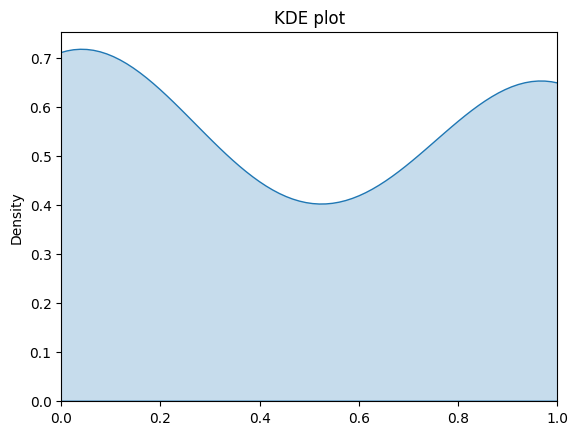

In [0]:
sns.kdeplot(y_pred,fill=True)
plt.xlim(0, 1)
plt.title("KDE plot")
push_figure("kde_plot.png", plt.gcf())
plt.show()

Calculate Metrics 

In [0]:
def get_model_metrics(
    y_test: pd.DataFrame, y_pred_probablity: pd.Series, y_pred_label: pd.Series
) -> dict:
   
    # pred_threshold = np.percentile(y_pred_probablity, 60)
    # y_pred_label = np.where(y_pred_probablity >= pred_threshold, 1, 0)

    metrics = {
        "logloss": log_loss(y_test, y_pred_probablity),
        "accuracy": accuracy_score(y_test, y_pred_label),        
        "f1_score": f1_score(y_test, y_pred_label),
        "f05_score": fbeta_score(y_test, y_pred_label, beta=0.5),
        "precision_score": precision_score(y_test, y_pred_label),
        "recall_score": recall_score(y_test, y_pred_label),
        "roc_auc_score": roc_auc_score(y_test, y_pred_probablity),
        "y_real_mean": y_test.mean(),
        "y_pred_mean": y_pred_probablity.mean(),
    }
    return metrics

In [0]:
metrics = get_model_metrics(
   Y,y_pred,y_pred_abs)

In [0]:
for (metric_name, metric_value) in metrics.items():
    push_metric(metric_name, metric_value)

Adding metric logloss: 0.06591811169448782
Adding metric accuracy: 0.9375
Adding metric f1_score: 0.9333333333333333
Adding metric f05_score: 0.8974358974358975
Adding metric precision_score: 0.875
Adding metric recall_score: 1.0
Adding metric roc_auc_score: 1.0
Adding metric y_real_mean: 0.4375
Adding metric y_pred_mean: 0.47931970512258254


Save Predictions 


In [0]:
preddf['Prediction'] = (y_pred >= y_pred_threshold).astype(int)
preddf['Prediction_raw'] = y_pred
preddf.to_csv("../data/predictions.csv", index=False)
push_artifact("../data/predictions.csv")

Adding artifact predictions.csv


In [0]:
preddf

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Target,hour,day,weekday,month,year,BMI_HOMA,L_A_ratio,Prediction,Prediction_raw
0,86.0,21.111111,92.00,1.514907,0.805386,2.041142,4.819240,2.448964,6.652760,0,2,14.0,5,6,2025,17.002602,0.423540,0,5.089920e-01
1,44.0,20.760000,86.00,2.146282,1.600000,2.714032,20.320000,2.156403,4.219891,0,16,7.0,5,6,2025,33.216000,0.133565,0,2.325717e-01
2,32.0,36.512637,87.00,2.709782,3.009980,3.919449,5.100000,2.896035,6.379207,0,8,17.0,1,6,2025,109.902294,0.768519,0,1.918308e-03
3,45.0,37.035608,83.00,2.048982,1.383997,3.713089,4.617125,2.272588,6.375319,0,6,18.0,2,6,2025,51.257183,0.804199,0,4.554870e-10
4,35.0,35.250761,90.00,2.056301,1.513374,3.943704,6.966895,3.137103,6.505676,0,20,15.0,6,6,2025,53.347585,0.566063,0,2.655789e-07
5,28.0,35.855815,87.00,2.259260,1.840410,4.241474,4.794200,3.111008,5.885059,0,18,3.0,1,6,2025,65.989386,0.884709,0,2.303406e-06
6,69.0,32.500000,93.00,1.860975,1.245642,2.781610,11.787960,2.548504,5.602643,0,17,6.0,4,6,2025,40.483365,0.235970,0,3.859536e-05
7,78.0,25.300000,70.00,1.505854,0.519184,2.032481,10.567295,1.734095,5.350668,0,8,4.0,2,6,2025,13.135355,0.192337,0,3.460911e-08
8,69.0,29.400000,89.00,2.459931,2.349885,3.834537,8.286300,1.710188,5.378832,0,2,7.0,5,6,2025,69.086613,0.462756,0,1.927764e-05
9,68.0,21.082813,102.00,1.974081,1.559920,2.370188,8.574655,2.690730,6.108801,1,7,13.0,4,6,2025,32.887502,0.276418,1,9.999969e-01


Log artefacts in mlFlow

In [0]:

if mlflow.active_run() == None:
    raise Exception("The run hasn't been started, guessing you don't want a partially complete experiment")

# ADD other metrics
for (metric_name, metric_value) in mlflow_metrics.items():
    print(f"logging other metric: {metric_name}=metric_value")
    mlflow.log_metric(metric_name, metric_value)

for (figure_name, figure) in mlflow_figures.items():
    print(f"logging figure: {figure_name}")
    mlflow.log_figure(figure, figure_name)

for (table_name, table_df) in mlflow_tables.items():
    print(f"logging table: {table_name}")
    mlflow.log_table(table_df, table_name)

from mlflow.data.pandas_dataset import PandasDataset
dataset: PandasDataset = mlflow.data.from_pandas(preddf)
mlflow.log_input(dataset, context="prediction")

logging other metric: Average raw probability=metric_value
logging other metric: logloss=metric_value
logging other metric: pred_threshold=metric_value
logging other metric: accuracy=metric_value
logging other metric: f1_score=metric_value
logging other metric: f05_score=metric_value
logging other metric: precision_score=metric_value
logging other metric: recall_score=metric_value
logging other metric: roc_auc_score=metric_value
logging other metric: y_real_mean=metric_value
logging other metric: y_pred_mean=metric_value
logging other metric: iterations=metric_value
logging figure: kde_plot.png


/local_disk0/.ephemeral_nfs/envs/pythonEnv-ab449165-2923-4171-934a-a8e0e572f42f/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [0]:
if run:
  mlflow.end_run()
  print(f"run complete for: {run.info.run_name}")
  mlflow.lightgbm.autolog(disable=True)
  run = None

run complete for: cancer_classification_prediction_2025-06-18 11:40:47
